The goal of this notebook is to recalibrate the intercepts of the baseline and cohort afib models (and the age coefficient of the cohort model separately), so that the simulation reproduces
the global burdain of disease estimates for atrial fibrilation and fluttering prevalence for 2019 in the US. 

This notebook manually modifies the intercept of the model, obtains an updated estimate of the afib prevalence and then adjusts the
intercept accordingly. A fixed number of iterations is used and empirically we verify that the choice of intercept steps, which
adjust during the iterations, are reasonable.

The metric used to define the difference between the GBD and the simulation was using the afib prevalence that are the highest among the population (ie older ages). No attempt was made to map this metric to a change in the intercept model (ie use a slope and a change to find the change in the intercept as is done in the Newton method). The initial change in the intercept was found empirically.

An attempt was made to adjust the age coefficient after the intercept was adjusted (both for the cohort afib model).

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

In [2]:
from microsim.data_loader import load_model_spec, load_regression_model
from microsim.population import NHANESDirectSamplePopulation, initializeAFib
from microsim.sim_settings import simSettings
from microsim.statsmodel_logistic_risk_factor_model import StatsModelLogisticRiskFactorModel
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
from microsim.stats_model_linear_probability_risk_factor_model import (StatsModelLinearProbabilityRiskFactorModel)
from microsim.statsmodel_linear_risk_factor_model import StatsModelLinearRiskFactorModel

In [3]:
gbdData=pd.read_csv("/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA/IHME-GBD_2019_DATA-afib/IHME-GBD_2019_DATA-8086e0fc-1.csv")
#gbdData.head(3)

In [4]:
gbdData.loc[ (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235])),["age_id","age_name","val"]]

,age_id,age_name,val
31,16,55-59 years,0.017813
34,17,60-64 years,0.031653
37,18,65-69 years,0.056925
40,19,70-74 years,0.094122
43,20,75-79 years,0.140805
46,30,80-84,0.190387
49,31,85-89,0.224202
52,32,90-94,0.237910
61,235,95+ years,0.227766


In [5]:
#the reference afib data will be based on the 2019 US GBD data
afibRef = gbdData.loc[ 
    (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235]))
    ,["val"]]["val"].tolist()
#afibRef

In [6]:
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

In [7]:
intercept = load_regression_model("BaselineAFibModel")._coefficients["Intercept"]
interceptStep = 1
interceptChange = 0

popSize=50000

In [8]:
module = importlib.import_module("microsim.population")

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [9]:
if False: #decide if I will recalibrate the baseline afib model intercept or just use the one I found in the past
    
    #use this definition of the baseline afib model
    def initializeAFib(person):
        model = load_regression_model("BaselineAFibModel")
        statsModel = StatsModelLogisticRiskFactorModel(model)
        return statsModel.estimate_next_risk(person)

    setattr(module, "initializeAFib", initializeAFib)

    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

    #afibRisks = list()
    #for p in pop._people.iloc[:]:
    #    afibRisks += [p._afib[0]]
    #afibRisks

    #plt.hist(afibRisks,bins=10)
    #plt.show()

    #do the bin counting for the baseline model
    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age
        afibList += p._afib 
        pDone = len(ageList)
        if pDone%100000==0:
            print(pDone)
        
    baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
    baseAfib["age"]=baseAfib["age"].astype('int')
    baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

    baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

    labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
    values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
    reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    for i in range(len(reference)):
        ax.scatter(labels[i],reference[i],color="black")
    plt.xlabel("age group")
    plt.ylabel("mean afib risk")
    plt.title("nhanes baseline afib model")
    plt.show()

    #find how far off we are from the GBD prevalence
    afibSim = baseAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSum = sum( afibDiffWeighted)

    #define the change in the model intercept based on the difference
    if (afibDiffWeightedSum>0.):
        interceptChange += interceptStep
    else:
        interceptChange += -interceptStep
    
    #and now do this all over again
    for run in range(0,50):

        if (run%10==0):
            print(f"intercept= {intercept} step= {interceptStep} change= {interceptChange}")
        intercept += interceptChange
    
        def initializeAFib(person, intercept = intercept):
            model = load_regression_model("BaselineAFibModel")
            model._coefficients["Intercept"] = intercept
            #model._coefficients["age"] = model._coefficients["age"]*1
            statsModel = StatsModelLogisticRiskFactorModel(model)
            return statsModel.estimate_next_risk(person)

        setattr(module, "initializeAFib", initializeAFib)

        pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

        ageList = list()
        afibList = list()
        for p in pop._people.iloc[:]:
            ageList +=  p._age
            afibList += p._afib 
            pDone = len(ageList)
            #if pDone%100000==0:
                #print(pDone)
        
        baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
        baseAfib["age"]=baseAfib["age"].astype('int')
        baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

        baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
        baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

        afibSim = baseAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
        afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
        afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
        afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
        afibDiffWeightedSumOld = afibDiffWeightedSum
        afibDiffWeightedSum = sum( afibDiffWeighted)

        if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
            interceptStep = interceptStep/2
        if (afibDiffWeightedSum>0.):
            interceptChange = interceptStep
        else:
            interceptChange = -interceptStep
    

In [10]:
#obtain the last updated intercept for the baseline model
intercept += interceptChange
#or use the one I found in the past
intercept = -9.090481572055563

#use this updated intercept from now on
def initializeAFib(person, intercept = intercept):
    model = load_regression_model("BaselineAFibModel")
    model._coefficients["Intercept"] = intercept
    #model._coefficients["age"] = model._coefficients["age"]*1
    statsModel = StatsModelLogisticRiskFactorModel(model)
    return statsModel.estimate_next_risk(person)

setattr(module, "initializeAFib", initializeAFib)

In [11]:
# -9.091369874977811 with population 500000 (and many many hours)
# -9.090481572055563 with population 50000 (and a few mins)
intercept

-9.090481572055563

In [12]:
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

#do the bin counting for the baseline model
ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age
    afibList += p._afib 
    pDone = len(ageList)
    if pDone%100000==0:
        print(pDone)
        
baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
baseAfib["age"]=baseAfib["age"].astype('int')
baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

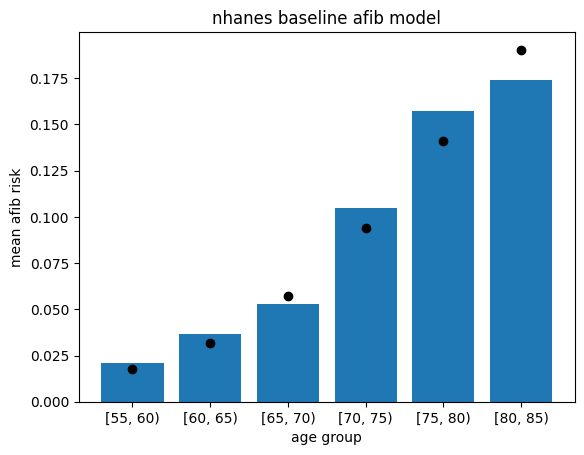

In [13]:
labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes baseline afib model")
plt.show()

In [14]:
popSize=10000

In [15]:
#we will do this now for the cohort afib model
#the difference is that now we need to advance the population and use the data from all person-years
module = importlib.import_module("microsim.cohort_risk_model_repository")

intercept = load_regression_model("afibCohortModel")._coefficients["Intercept"]
interceptStep = 0.25
interceptChange = 0

In [16]:
#try perhaps a custom model

class StatsAfibModel(StatsModelLinearRiskFactorModel):
    def __init__(self, regression_model):
        super().__init__(regression_model, False)

    def estimate_next_risk(self, person, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk(
            person
        )
        riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        return rng.uniform() < riskWithResidual 

    def estimate_next_risk_vectorized(self, x, rng=None):
        #rng = np.random.default_rng(rng)
        linearRisk = super().estimate_next_risk_vectorized(x)
        riskWithResidual = linearRisk + self.draw_from_residual_distribution(rng)
        return rng.uniform()  < riskWithResidual 

In [17]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
    model = load_regression_model(modelName)
    if (referenceName=="afib"):
        model._coefficients["Intercept"] = intercept
        #self._repository[referenceName] = StatsAfibModel(model)   #try the custom model
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #or the default model
        #print("intercept = ", intercept)
    else:
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository

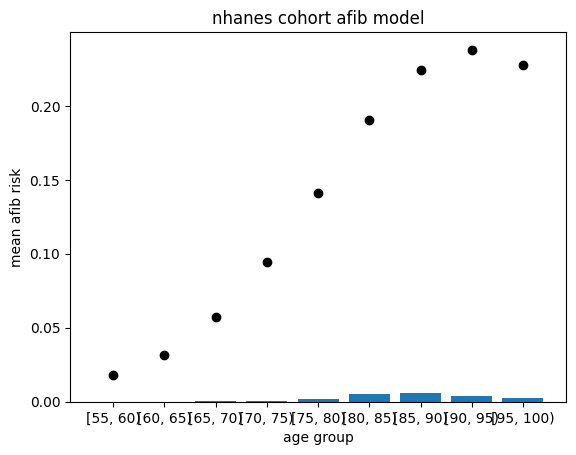

In [18]:
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
     #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [19]:
#afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
#afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
##afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
#afibDiffWeightedSumOld = afibDiffWeightedSum
#afibDiffWeightedSum = sum( afibDiffWeighted)##

#if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
#    interceptStep = interceptStep/2
#if (afibDiffWeightedSum>0.):
#    interceptChange = interceptStep
#else:
#    interceptChange = -interceptStep

In [20]:
#find how far off we are from the GBD prevalence
afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
#afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = [y/x for x,y in zip(afibRef,afibDiff)]
afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)]
afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
afibDiffWeightedSum = sum( afibDiffWeighted)

#define the change in the model intercept based on the difference
if (afibDiffWeightedSum>0.):
    interceptChange += interceptStep
else:
    interceptChange += -interceptStep

In [21]:
for run in range(0,10):

    #if (run%10==0):
    print(f"run= {run} intercept= {intercept} step= {interceptStep} change= {interceptChange}")
    intercept += interceptChange
    
    def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            #self._repository[referenceName] = StatsAfibModel(model) #use the custom model
            #print("intercept = ", intercept)
        #else:
            #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #and the default model for all else
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model) #or just use the default for all

    CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
    setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
    from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
    alive, dead = pop.advance_vectorized(150,rng=rngStream)

    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age[1:]
        afibList += p._afib[1:-1] 
        #pDone = len(ageList)
        #if pDone%100000==0:
         #   print(pDone)
        
    cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
    cohortAfib["afib"]=cohortAfib["afib"].astype('int')
    cohortAfib["age"]=cohortAfib["age"].astype('int')

    cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
    cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

    afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    #afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)] #weight according to number of cases
    afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)] #or all equally
    #afibDiffWeighted = [y/x for x,y in zip(afibRef,afibDiff)]
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSumOld = afibDiffWeightedSum
    afibDiffWeightedSum = sum( afibDiffWeighted)

    if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
        interceptStep = interceptStep/2
    if (afibDiffWeightedSum>0.):
        interceptChange = interceptStep
    else:
        interceptChange = -interceptStep

run= 0 intercept= 0.006808684735369566 step= 0.25 change= 0.25
run= 1 intercept= 0.25680868473536955 step= 0.125 change= -0.125
run= 2 intercept= 0.13180868473536955 step= 0.0625 change= 0.0625
run= 3 intercept= 0.19430868473536955 step= 0.0625 change= 0.0625
run= 4 intercept= 0.25680868473536955 step= 0.03125 change= -0.03125
run= 5 intercept= 0.22555868473536955 step= 0.03125 change= -0.03125
run= 6 intercept= 0.19430868473536955 step= 0.015625 change= 0.015625
run= 7 intercept= 0.20993368473536955 step= 0.015625 change= 0.015625
run= 8 intercept= 0.22555868473536955 step= 0.0078125 change= -0.0078125
run= 9 intercept= 0.21774618473536955 step= 0.0078125 change= -0.0078125


In [22]:
#run= 9 intercept= 0.21774618473536955 step= 0.00390625 change= 0.00390625

In [23]:
#obtain the last updated intercept for the cohort model
# 0.21969930973536955
intercept += interceptChange
#or just set it at the value I found in the past
#intercept = 0.21969930973536955 #for the original afib cohort model, using the rates as the weights
#intercept = -0.027371002764630448  #for the modified afib cohort model
intercept

0.21383993473536955

In [24]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            #self._repository[referenceName] = StatsAfibModel(model)
            #print("intercept = ", intercept)
        #else:
            #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
        #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

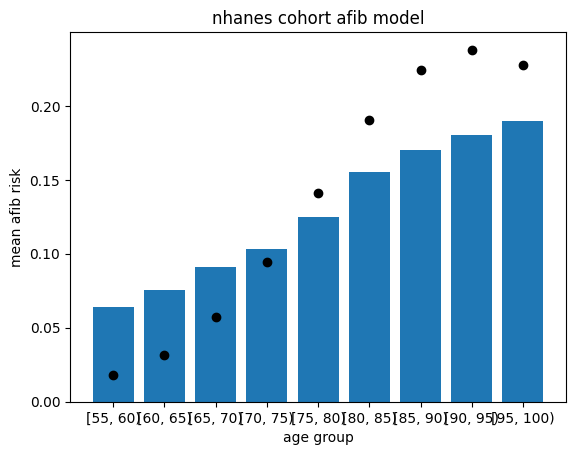

In [25]:
labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [ ]:
#now I will see if modifying the age coefficient improves things

In [ ]:
module = importlib.import_module("microsim.cohort_risk_model_repository")

ageCoeff = load_regression_model("afibCohortModel")._coefficients["age"]
ageStep = 0.0003
ageChange = 0

In [ ]:
#find how far off we are from the GBD prevalence
afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
afibDiffWeightedSum = sum( afibDiffWeighted)

#define the change in the model intercept based on the difference
if (afibDiffWeightedSum>0.):
    ageChange += ageStep
else:
    ageChange += -ageStep

In [ ]:
#popSize=10000

In [ ]:
#pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
#alive, dead = pop.advance_vectorized(150,rng=rngStream)

#ageList = list()
#afibList = list()
#for p in pop._people.iloc[:]:
#    ageList +=  p._age[1:]
#    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
     #   print(pDone)
        
#cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
#cohortAfib["afib"]=cohortAfib["afib"].astype('int')
#cohortAfib["age"]=cohortAfib["age"].astype('int')

#cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
#cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
#cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

#afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
#afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
##afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = [1*y for x,y in zip(afibRef,afibDiff)]
#afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
#afibDiffWeightedSumOld = afibDiffWeightedSum
#afibDiffWeightedSum = sum( afibDiffWeighted)

#if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
#    ageStep = ageStep/2
#if (afibDiffWeightedSum>0.):
#    ageChange = ageStep
#else:
#    ageChange = -ageStep

In [ ]:
for run in range(0,10):

    #if (run%10==0):
    print(f"run= {run} ageCoeff= {ageCoeff} ageStep= {ageStep} ageChange= {ageChange}")
    ageCoeff += ageChange
    
    def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
        model = load_regression_model(modelName)
        if (referenceName=="afib"):
            model._coefficients["Intercept"] = intercept
            model._coefficients["age"] = ageCoeff
            self._repository[referenceName] = StatsAfibModel(model)
            #print("intercept = ", intercept)
        else:
            self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
        #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    
    #def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
    #    model = load_regression_model(modelName)
    #    if (referenceName=="afib"):
    #        model._coefficients["Intercept"] = intercept
    #        model._coefficients["age"] = ageCoeff
    #       #print("intercept = ", intercept)
    #    self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

    CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
    setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
    from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
    pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
    alive, dead = pop.advance_vectorized(150,rng=rngStream)

    ageList = list()
    afibList = list()
    for p in pop._people.iloc[:]:
        ageList +=  p._age[1:]
        afibList += p._afib[1:-1] 
        #pDone = len(ageList)
        #if pDone%100000==0:
         #   print(pDone)
        
    cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
    cohortAfib["afib"]=cohortAfib["afib"].astype('int')
    cohortAfib["age"]=cohortAfib["age"].astype('int')

    cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
    cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
    cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

    afibSim = cohortAfibMeansByAgeGroup.iloc[1:]["afib"].tolist()
    afibDiff = [x-y for x,y in zip(afibRef,afibSim)]
    afibDiffWeighted = [x*y for x,y in zip(afibRef,afibDiff)]
    afibDiffWeighted = list(filter(lambda x: ~np.isnan(x), afibDiffWeighted))
    afibDiffWeightedSumOld = afibDiffWeightedSum
    afibDiffWeightedSum = sum( afibDiffWeighted)

    if (afibDiffWeightedSum*afibDiffWeightedSumOld<0) :
        ageStep = ageStep/2
    if (afibDiffWeightedSum>0.):
        ageChange = ageStep
    else:
        ageChange = -ageStep

In [ ]:
#obtain the last updated age coefficient for the cohort model
ageCoeff += ageChange
#or just set it at the value I found in the past
# ageCoeff = 0.001143730313827605
ageCoeff

In [ ]:
def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
    model = load_regression_model(modelName)
    if (referenceName=="afib"):
        model._coefficients["Intercept"] = intercept
        model._coefficients["age"] = ageCoeff
        self._repository[referenceName] = StatsAfibModel(model)
        #print("intercept = ", intercept)
    else:
        self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    #self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)
    
#def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
#    model = load_regression_model(modelName)
#    if (referenceName=="afib"):
#        model._coefficients["Intercept"] = intercept
#        model._coefficients["age"] = ageCoeff
#       #print("intercept = ", intercept)
#    self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
    #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

In [ ]:
labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()

In [ ]:
ageCoeff

In [ ]:
#set it
ageCoeff = 0.0009656053138276052*1.2

def _initialize_linear_probability_risk_model(self, referenceName, modelName, intercept=intercept, ageCoeff=ageCoeff):
    model = load_regression_model(modelName)
    if (referenceName=="afib"):
        model._coefficients["Intercept"] = intercept
        model._coefficients["age"] = ageCoeff
        #print("intercept = ", intercept)
    self._repository[referenceName] = StatsModelLinearProbabilityRiskFactorModel(model)

CohortRiskModelRepository._initialize_linear_probability_risk_model = _initialize_linear_probability_risk_model
setattr(module, "CohortRiskModelRepository", CohortRiskModelRepository)
from microsim.cohort_risk_model_repository import CohortRiskModelRepository
    
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)
alive, dead = pop.advance_vectorized(150,rng=rngStream)

ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
    #pDone = len(ageList)
    #if pDone%100000==0:
    #   print(pDone)
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

In [ ]:
labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()